# Assignment 2: fMRI data analysis of Iowa Gambling task


<div class="alert alert-success" role="alert">

#### Activate the virtual environment:

```bash
. /work/<MY DIRECTORY NUMBER>/virt_env/bin/activate
python -m ipykernel install --user --name=virt_env
echo Done! Remember changing the kernel in Jupyter.
```
</div>

In [1]:
# ACTIVATING VIRTUAL ENVIRONMENT

import os
path='/work/student_folders/Justina_folder/notebooks_fMRI' # Change it to your own path
os.chdir(path)
!/work/student_folders/Justina_folder/notebooks_fMRI/activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


### 1.1 Import the modules

In [29]:
# PYTHON BUILT-IN LIBRARIES
import os
import pickle
from datetime import datetime  # For extra functionality
import inspect
import pip

# DATA MANIPULATION 

import numpy as np
import pandas as pd

# MACHINE LEARNING 

from sklearn import naive_bayes, model_selection
from sklearn.model_selection import train_test_split, GroupKFold

# DATA VISUALIZATION 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_img, show, plot_contrast_matrix
from nilearn.reporting import get_clusters_table

# NEUROIMAGING & STATISTICAL ANALYSIS

from nilearn import image, decoding
from nilearn.image import mean_img, new_img_like, load_img, index_img, clean_img, concat_imgs

# STATISTICAL ANALYSIS AND FIRST-LEVEL GLM

from nilearn.glm.first_level import first_level_from_bids, make_first_level_design_matrix

# SEARCHLIGTH 

from nilearn.decoding import SearchLight

from scipy.stats import norm


### 1.2 BIDS dataset first and second level analysis



In [2]:
# Import some functionality
now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Starting cell: 14:35:37
Finishing cell: 14:35:37


### 1.3 Fetch faceWord BIDS dataset
The Iowa dataset is located in the `fMRI_data/BID_2024E` folder.



#### Investigating the BIDS structure

In [3]:
def list_files(startpath):
    """ 
    Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. 
    """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
data_dir='/work/fMRI_data/BIDS_2024E/' 
derivatives_dir=  '/work/fMRI_data/BIDS_2024E/derivatives/'   
#If you want to plot the BIDS file tree
#list_files(derivatives_dir)

### 1.4 Obtain automatically FirstLevelModel objects and fit arguments

In [4]:
#BIDS directory
data_dir='/work/fMRI_data/BIDS_2024E/'

# BIDS derivatives (contains preprocessed data)
derivatives_dir='/work/fMRI_data/BIDS_2024E/derivatives' 

# Name for experiment in the BIDS directory
task_label = 'boldiowa'

# Label for data that are spatially aligned to the MNI152 template (i.e. spatially normalised)
space_label ='MNI152NLin2009cAsym'

#Run the function that can gather all the needed info from a BIDS folder
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label, derivatives_folder=derivatives_dir, n_jobs=-2, verbose=1,
        img_filters=[('desc', 'preproc')])

#Print the data from the first participant as sanity check
print(models_run_imgs[0])

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1398: UserWarning: 'slice_time_ref' provided (0.0) is different from the value found in the BIDS dataset (0.462).
Note this may lead to the wrong model specification.
  warn(
/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 

Found the following 4 preprocessed BOLD files
 for subject 0139
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0139
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0139/ses

/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0138
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0138/ses-001/func/sub-0138_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0138/ses-001/func/sub-0138_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0138/ses-001/func/sub-0138_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0138/ses-001/func/sub-0138_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0138
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0138/ses-001/func/sub-0138_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0138/ses

/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0142
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0142
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0142/ses-001/func/sub-0142_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0142/ses

/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0136
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0136
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0136/ses-001/func/sub-0136_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0136/ses

/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


Found the following 4 preprocessed BOLD files
 for subject 0140
 for filter: [('task', 'boldiowa'), ('desc', 'preproc')]:
 ['/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

Found the following 4 events files
 for subject 0140
 for filter: [('task', 'boldiowa')]:
 ['/work/fMRI_data/BIDS_2024E/sub-0140/ses-001/func/sub-0140_ses-001_task-boldiowa_run-1_echo-1_events.tsv', '/work/fMRI_data/BIDS_2024E/sub-0140/ses

/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1454: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  events = _get_events_files(
/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1467: UserWarning: The filter ('desc', 'preproc') will be skipped. 'desc' is not among the supported filters. Allowed filters include: ['sub', 'ses', 'task', 'acq', 'ce', 'rec', 'dir', 'run', 'echo', 'part']
  confounds = _get_confounds(


['/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/fMRI_data/BIDS_2024E/derivatives/sub-0139/ses-001/func/sub-0139_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
Finishing cell: 14:35:50


### 1.5 Sort the data to have a consistent order of participant IDs

In [5]:
n=len(models)
sub_labels=list()
print('Original order of data:')
for xx in range(n):
    sub_labels.append(models[xx].subject_label)
    print(sub_labels[xx])

sort_list=np.argsort(sub_labels)
print(sort_list)
models=[models[i] for i in sort_list]
models_run_imgs=[models_run_imgs[i] for i in sort_list]
models_events=[models_events[i] for i in sort_list]
models_confounds=[models_confounds[i] for i in sort_list]

sub_labels_new=list()
print('New order of data:')
for xx in range(n):
    sub_labels_new.append(models[xx].subject_label)
    print(sub_labels_new[xx])

Original order of data:
0139
0141
0138
0142
0136
0140
[4 2 0 5 1 3]
New order of data:
0136
0138
0139
0140
0141
0142


In [6]:
#Get the argument from the function
args=inspect.getfullargspec(first_level_from_bids)

#Make a dataframe to display arguments (skip the first two ('dataset_path' and 'task_label') that have no defaults
df = pd.DataFrame(args.defaults,args.args[2:])
print(df)

#Same info can also be obtained by writing first_level_from_bids?

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

                                        0
space_label                          None
sub_labels                           None
img_filters                          None
t_r                                  None
slice_time_ref                        0.0
hrf_model                          glover
drift_model                        cosine
high_pass                            0.01
drift_order                             1
fir_delays                            [0]
min_onset                             -24
mask_img                             None
target_affine                        None
target_shape                         None
smoothing_fwhm                       None
memory              Memory(location=None)
memory_level                            1
standardize                         False
signal_scaling                          0
noise_model                           ar1
verbose                                 0
n_jobs                                  1
minimize_memory                   

Here, we can see that the function uses information about `t_r` (TR), `HRF_model` (hemodynamic response function),``drift_model`` and `high_pass` (both used for high-pass filtering), `noise_model`(used for modelling auto correlation). In other words, this function seems to implement all the elements, we have been going through in previous tutorials.

### 1.6 Quick sanity check on fit arguments

In [7]:
#Get the file names for subj0141 functional data
func01=([os.path.basename(run) for run in models_run_imgs[4]])
print(func01)

['sub-0141_ses-001_task-boldiowa_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0141_ses-001_task-boldiowa_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0141_ses-001_task-boldiowa_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0141_ses-001_task-boldiowa_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


In [8]:
#Get the full path
func01_path=([os.path.abspath(run) for run in models_run_imgs[4]])

#Load the image and inspect data size
func_img = image.load_img(func01_path)
print("Shape of functional MRI image: %s" % (func_img.shape,))

Shape of functional MRI image: (78, 92, 78, 2400)


The data contains 4x600 = 2400 volumes with a 78 x 92 x78 voxel resolution.

In [9]:
print(models[4])

FirstLevelModel(n_jobs=-2, subject_label='0141', t_r=1, verbose=1)


Here, we see that the model is a `FirstLevelModel` object ([See here for details](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html)). This means that it incorporates all the same default values for setting up and estimating GLM-fMRI models as in the `first_level_from_bids`, unless else is mentioned. 

Here, we see the additional information that data were obtained with a TR of 1.0 seconds.

fmriprep exports a large number of [confounding parameters](https://fmriprep.org/en/stable/outputs.html#confounds) which can be used to regress out noise in the data. These are saved in a .tsv file in the derivatives folder (func) with the name `sub-00xx_task-EPIsequencewords_run-1_desc-confounds_timeseries.tsv`.

These are automatically imported into the `model_confounds` variable.
Let's inspect what we find in the `models_confounds` variable.

In [10]:
#Print model confounds for subj0141 participant, first run
print(models_confounds[4][0].columns)

Index(['global_signal', 'global_signal_derivative1',
       'global_signal_derivative1_power2', 'global_signal_power2', 'csf',
       'csf_derivative1', 'csf_power2', 'csf_derivative1_power2',
       'white_matter', 'white_matter_derivative1',
       ...
       'rot_x_power2', 'rot_x_derivative1_power2', 'rot_y',
       'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2',
       'rot_z_power2'],
      dtype='object', length=412)


In [11]:
confound_friston24 = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

confound_friston24_GSR = ['global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2','trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

# Subset confounds with selection
for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_friston24_GSR]
        #Removing NAs in the first row.
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1


#Print new confounds, for first participant, first run
print(models_confounds[4][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['global_signal', 'global_signal_derivative1', 'global_signal_power2',
       'global_signal_derivative1_power2', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'trans_x_derivative1', 'trans_y_derivative1',
       'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1',
       'rot_z_derivative1', 'trans_x_power2', 'trans_y_power2',
       'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2'],
      dtype='object')
Finishing cell: 14:52:05


In [13]:
events_sub= ['onset','duration','trial_type']

# Subset confounds with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
    models_events[ii][:]=events1


#Print new confounds, for first participant, first run
print(models_events[4][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['onset', 'duration', 'trial_type'], dtype='object')
Finishing cell: 14:52:11




We can see check how many trials were in each condition:

In [14]:
# Allows to check how many trials were in each condition:

print(models_events[4][0]['trial_type'].value_counts())
print(models_events[4][1]['trial_type'].value_counts())
print(models_events[4][2]['trial_type'].value_counts())
print(models_events[4][3]['trial_type'].value_counts())

trial_type
decks      40
win        30
loss        6
neutral     4
Name: count, dtype: int64


### 2.1 First level (single subject) model estimation
Now, that we have seen that the `first_level_from_bids` function gathers everything we need for analysis, we can get going with the analysis


#### Analysing one participant - subject 0141

Analysing data of the participant by generating a report of the process and the results.

In [15]:
# Getting the data and modeling info for our subject: 

model4=models[4]
imgs4=models_run_imgs[4]
events4=models_events[4]
confounds4=models_confounds[4]

# Fit the model
#model4.fit(imgs4,events4,confounds4)
#model4.zmap=model4.compute_contrast('decks-win')

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Finishing cell: 14:52:16


### 2.2 Creating new design matrices with a column per experimental trial

In [16]:
lsa_dm=[]

# Changing the model for a single participant (the first):
for ii in range(len(models_events[4])):
    # Sort onsets by trial type to make later processing easier
    #models_events[0][ii].sort_values(by=['trial_type'], inplace=True)
     #N=number of events
    N=models_events[4][ii].shape[0]
    # time frame with 600 scans with 1s TR:
    t_fmri = np.linspace(0, 600,600,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(models_events[4][ii], columns=['onset'])
    trials.loc[:, 'duration'] = 2 # decks are actually 5 s, but we will simplify
    trials.loc[:, 'trial_type'] = [models_events[4][ii]['trial_type'][i-1]+'_'+'t_'+str(i).zfill(3)  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        add_regs=models_confounds[4][ii], #Add the confounds from fmriprep
        hrf_model='glover',
        drift_model='cosine'  
    ))


now = datetime.now()
print('Finish making single trial models:',now.strftime("%H:%M:%S"))

/work/student_folders/Justina_folder/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


Finish making single trial models: 14:52:48


### 2.3 Check out the created design matrix

In [19]:
#print(lsa_dm)

### 2.4 Plotting the new design matrices


Finishing cell: 14:53:06


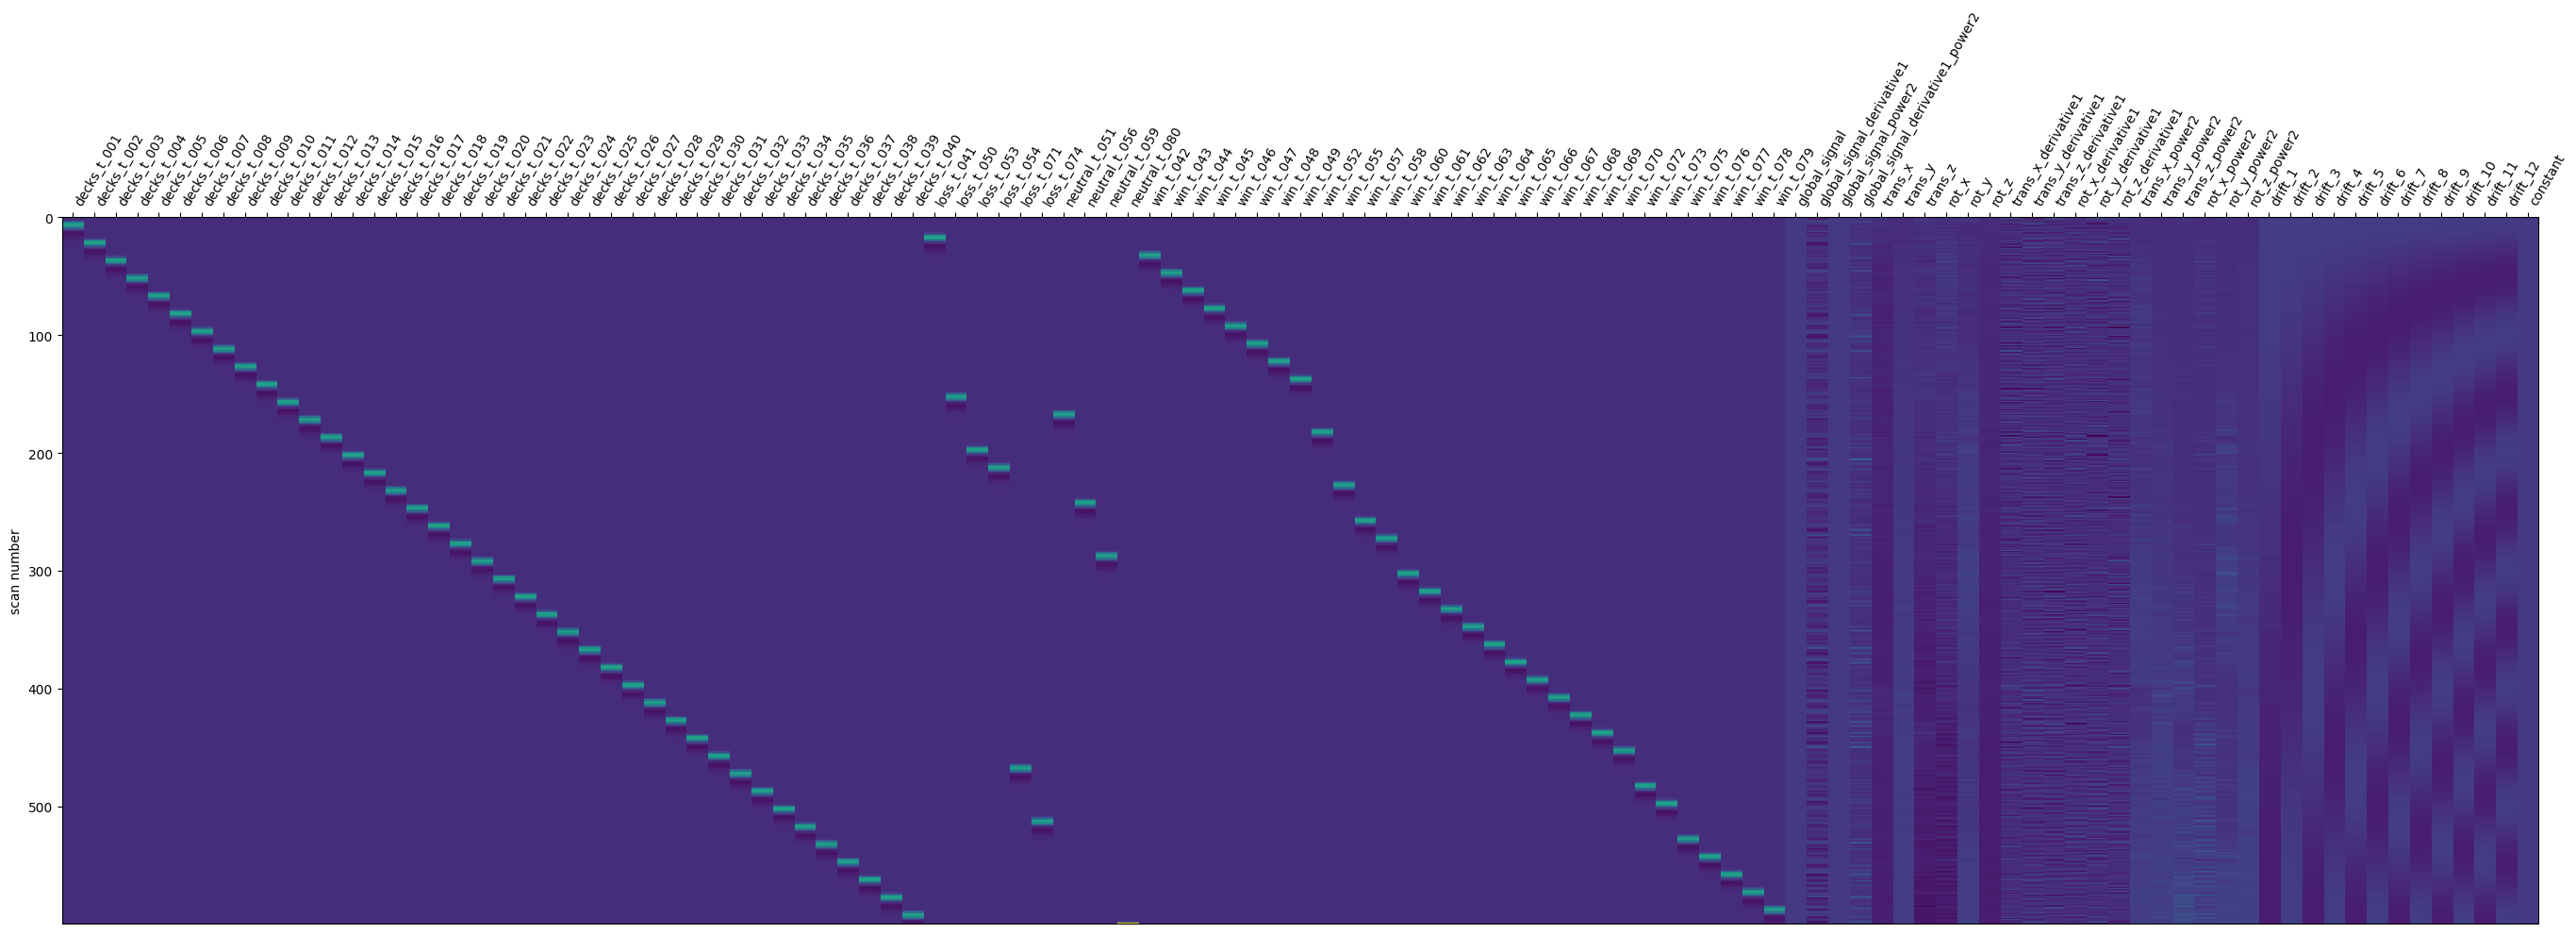

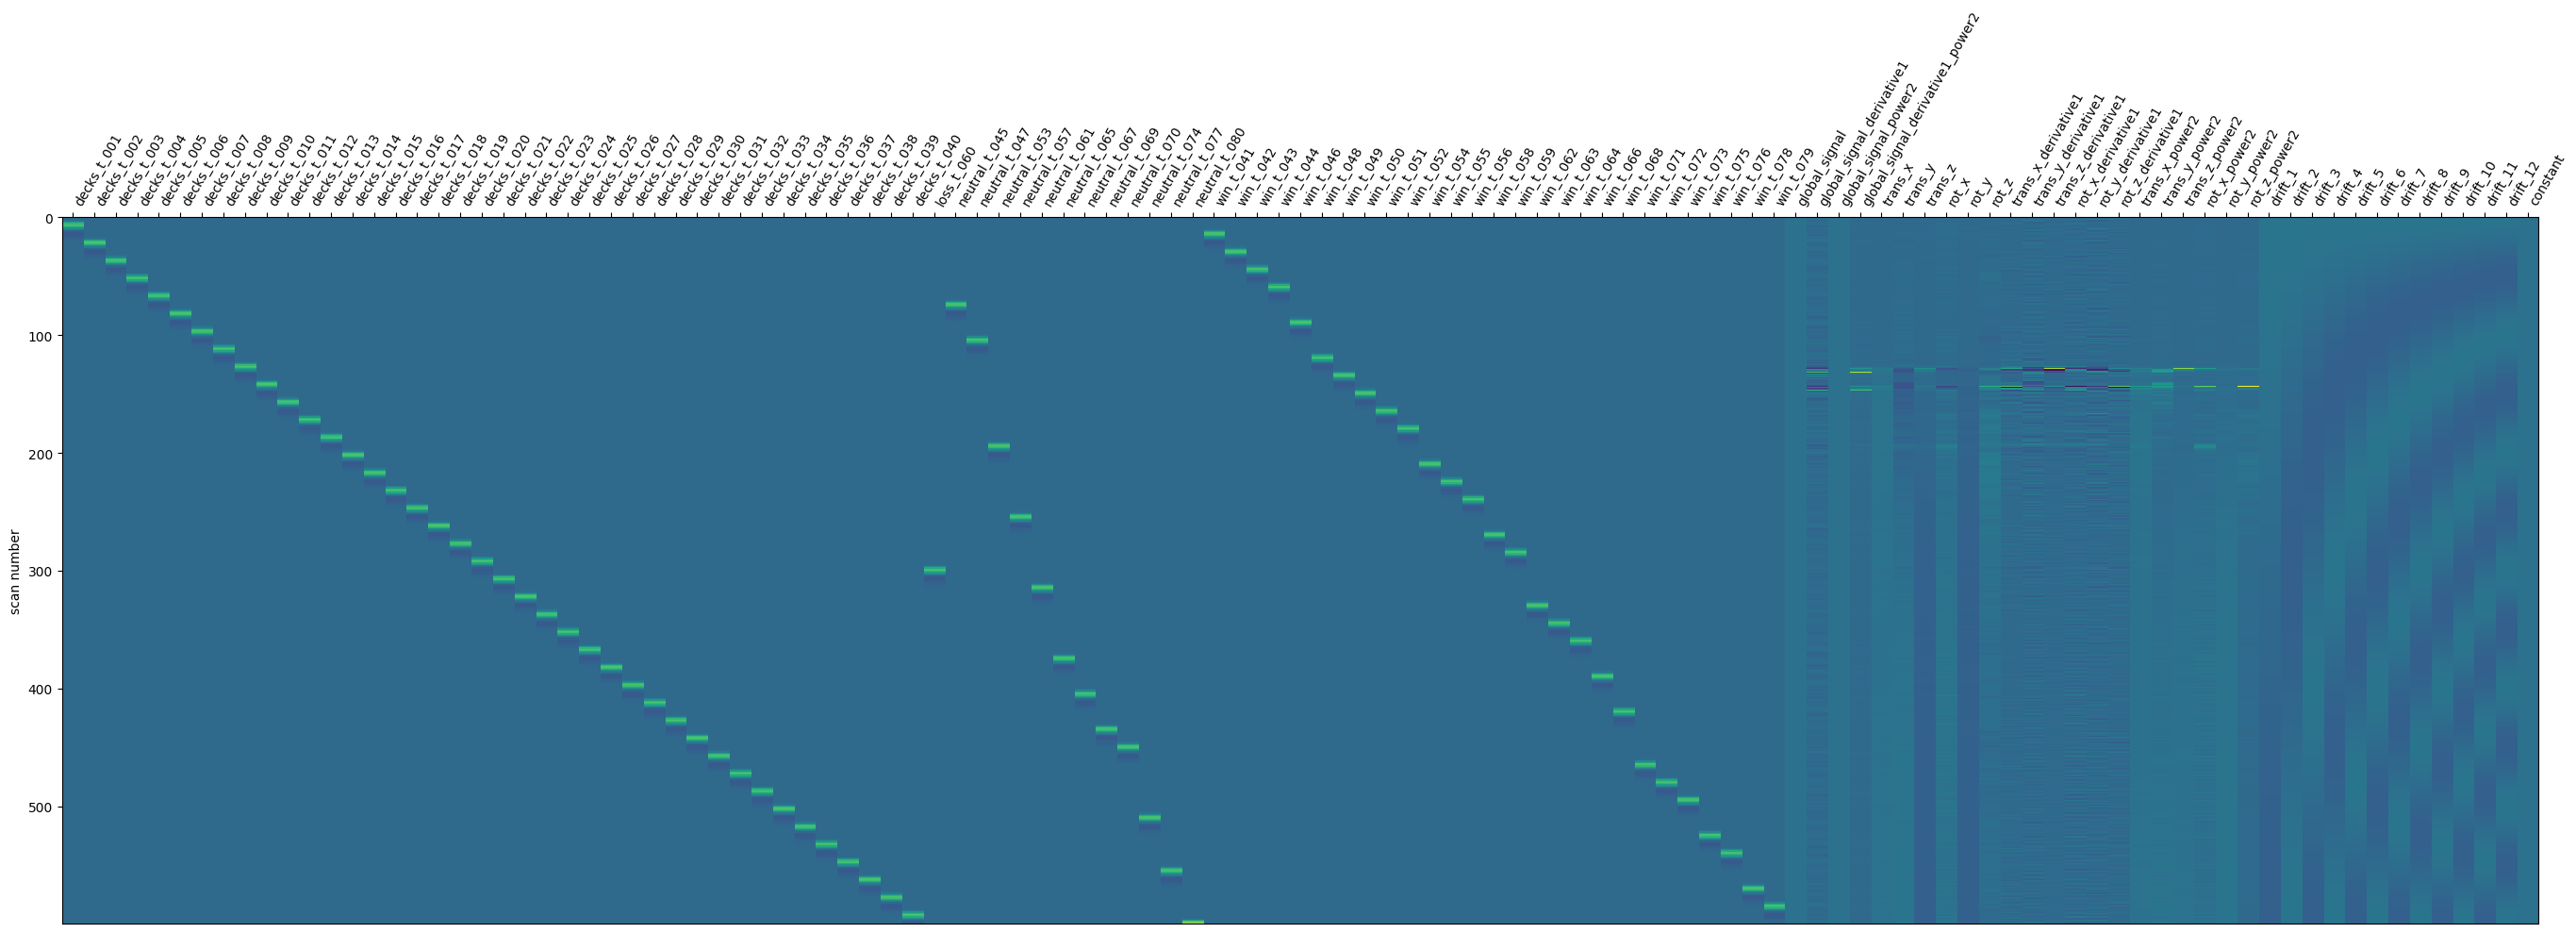

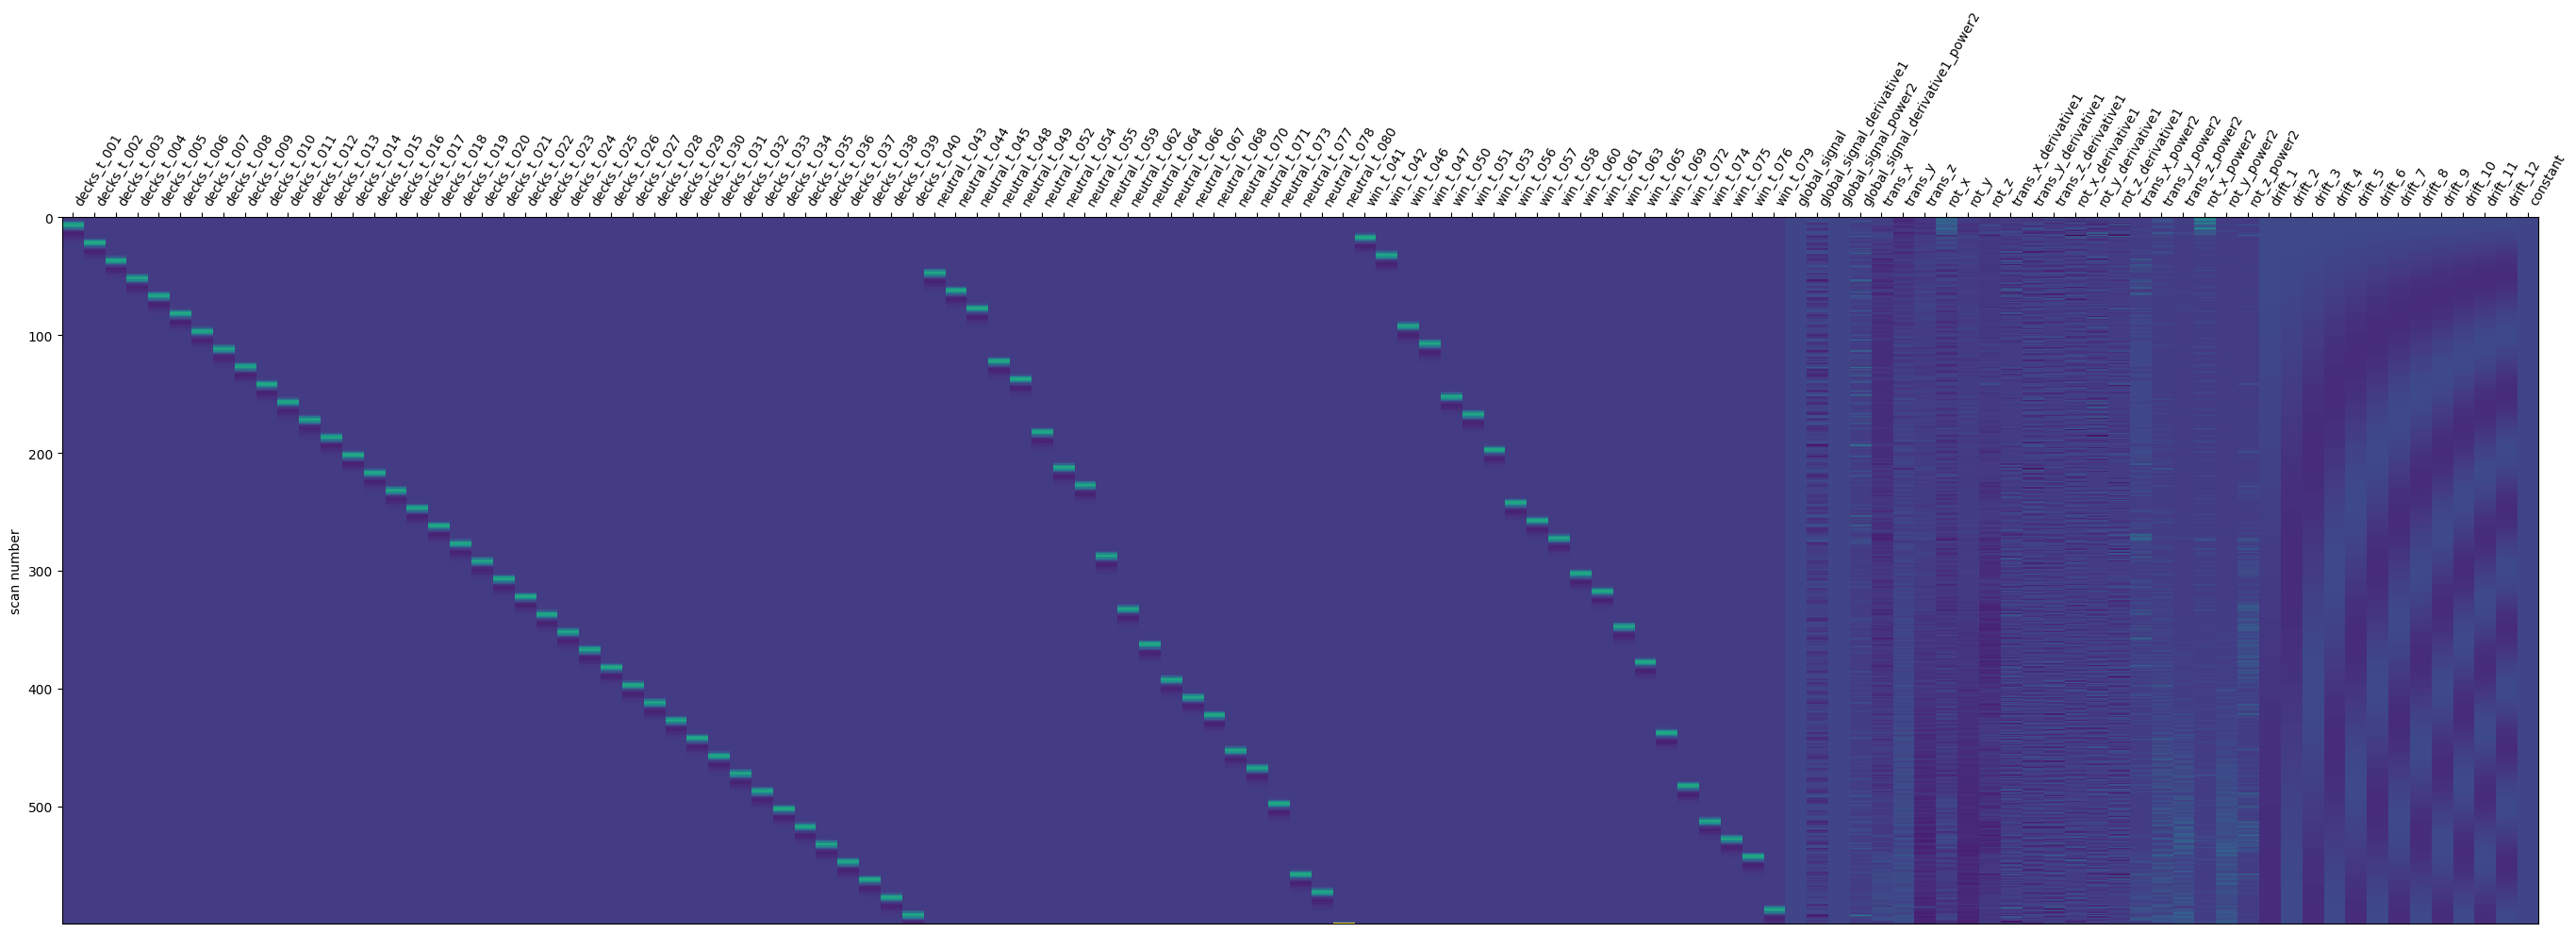

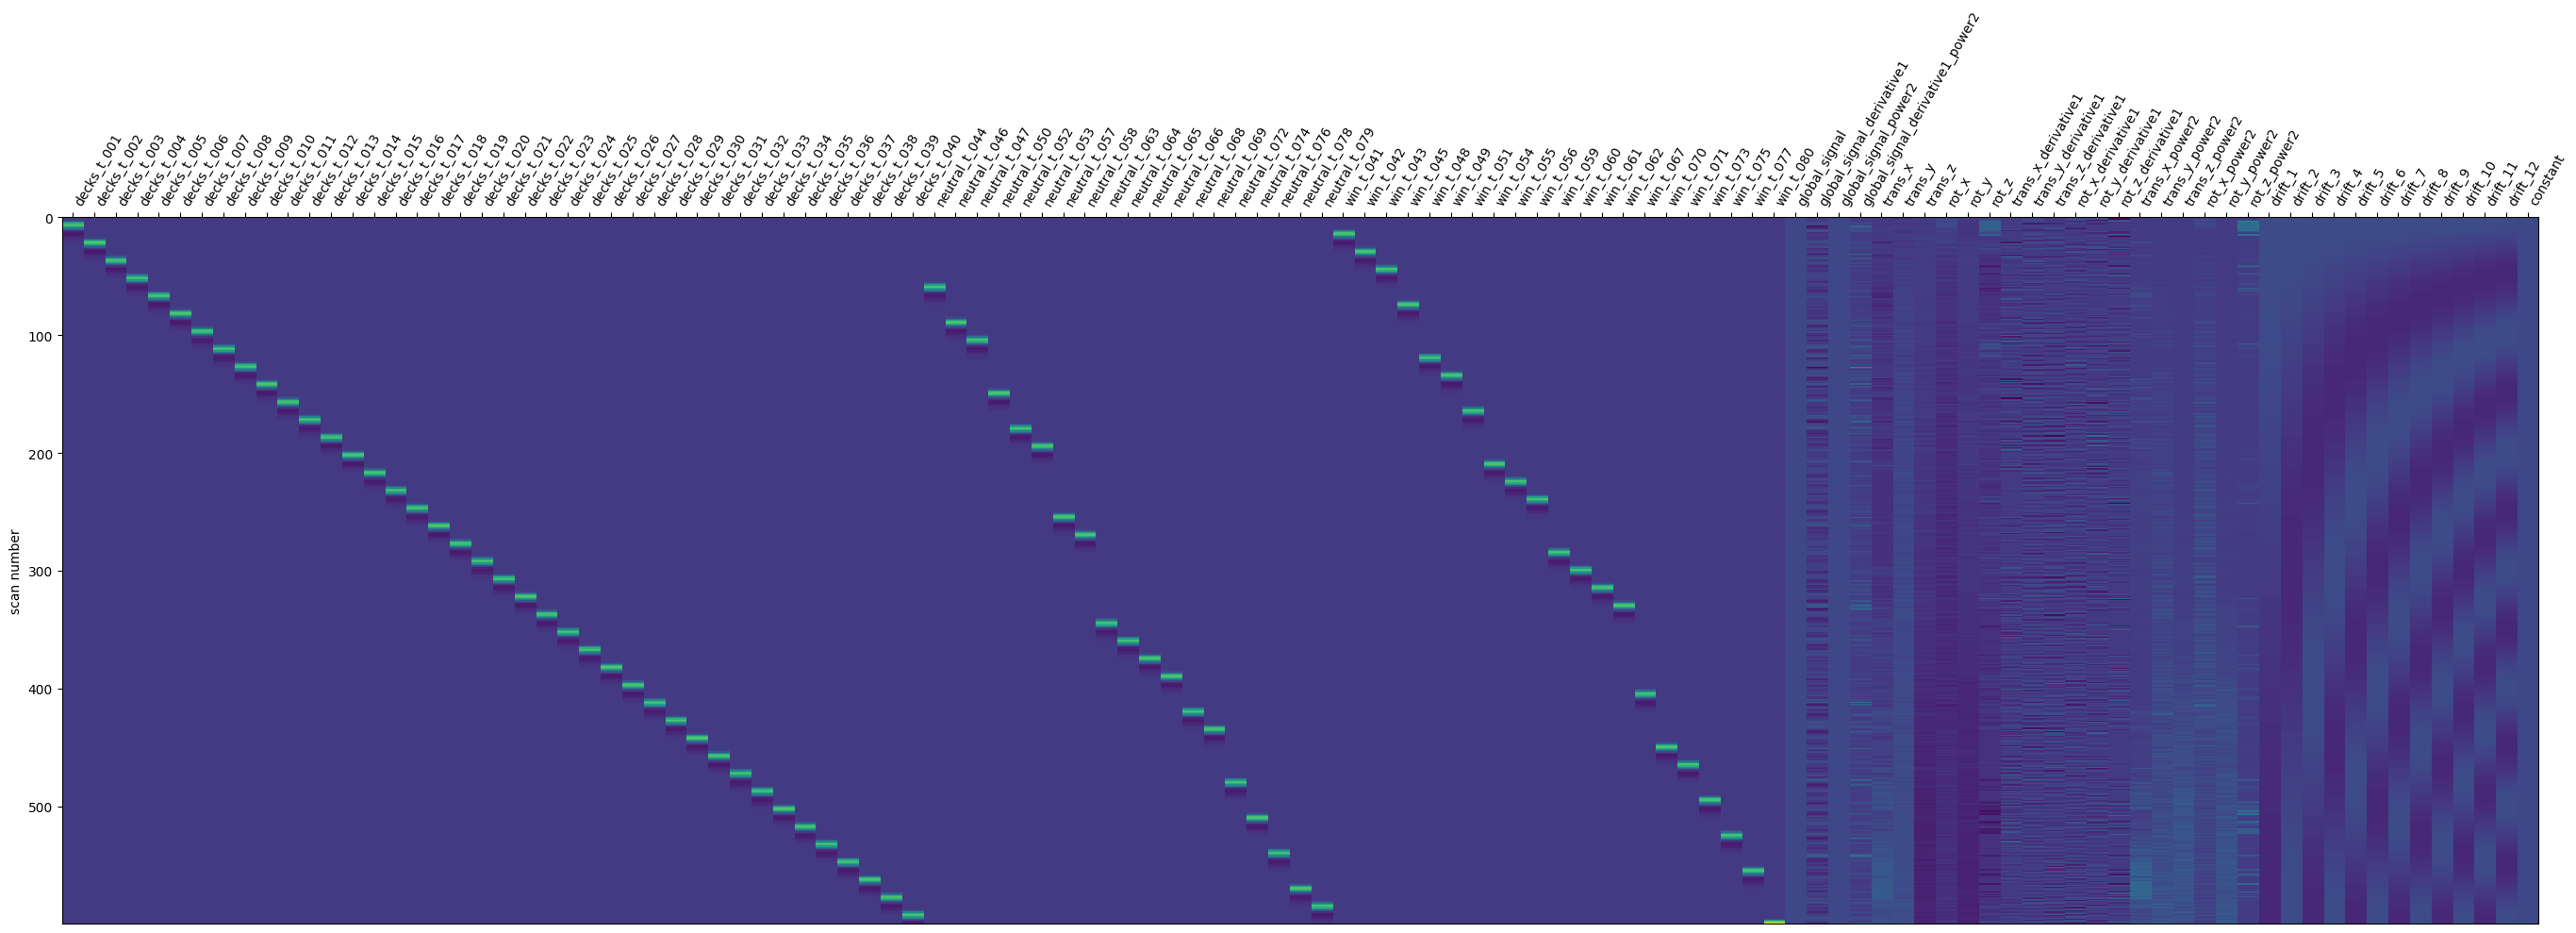

In [17]:
from nilearn.plotting import plot_design_matrix
for ii in range(len(models_events[4])):
    plot_design_matrix(lsa_dm[ii]);

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### 2.5 Inspecting the correlational structure of the design matrix

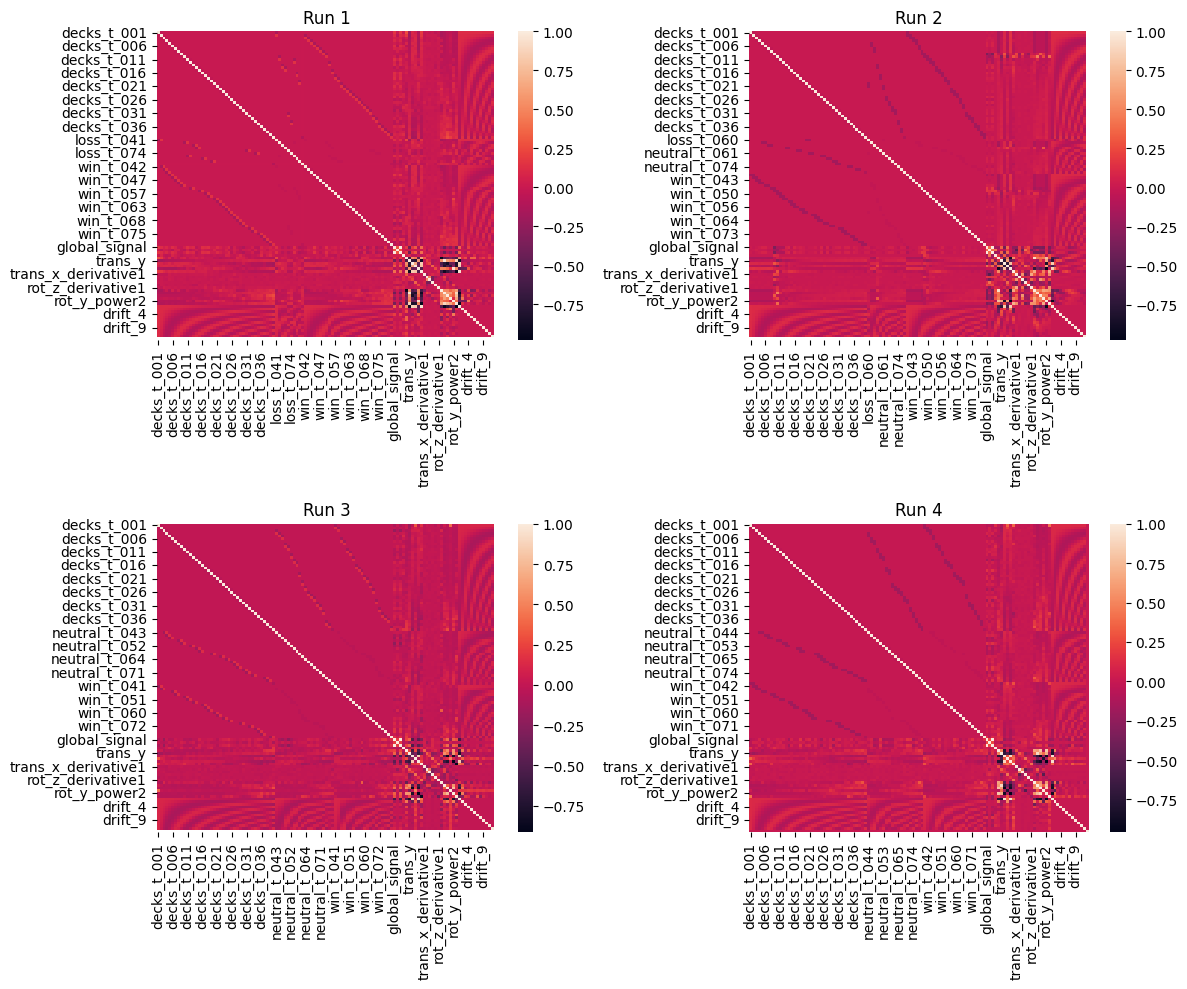

In [22]:
dm_corr_1 =lsa_dm[0].corr()

dm_corr_2 =lsa_dm[1].corr()

dm_corr_3 =lsa_dm[2].corr()

dm_corr_4 =lsa_dm[3].corr()

# Creating a subplot grid:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot design matrices in their own subplot:
sns.heatmap(dm_corr_1, ax=axes[0, 0])
axes[0, 0].set_title('Run 1')

sns.heatmap(dm_corr_2, ax=axes[0, 1])
axes[0, 1].set_title('Run 2')

sns.heatmap(dm_corr_3, ax=axes[1, 0])
axes[1, 0].set_title('Run 3')

sns.heatmap(dm_corr_4, ax=axes[1, 1])
axes[1, 1].set_title('Run 4')

plt.tight_layout()
plt.show()

### 3. Fit the models for all sessions from one participant

In [18]:
from nilearn.glm.first_level import FirstLevelModel

model1=[]
for ii in range(len(models_events[4])):
    
    # Get data and model info for 4th participant, 1st session
    imgs1=models_run_imgs[4][ii]
    model1.append (FirstLevelModel())
    #Fit the model
    print('Fitting GLM: ', ii+1)
    model1[ii].fit(imgs1,design_matrices=lsa_dm[ii])

now = datetime.now()
print('Finishing model fit:',now.strftime("%H:%M:%S"))

Fitting GLM:  1
Fitting GLM:  2
Fitting GLM:  3
Fitting GLM:  4
Finishing model fit: 15:30:56


### 4.1 Making beta map contrasts from the fitted model to use in later analysis

In [21]:
now = datetime.now()
print('Computing contrasts:',now.strftime("%H:%M:%S"))
b_maps = []
conditions_label = []

for ii in range(len(models_events[4])):
    N=models_events[4][ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N)
    #print(contrasts.shape)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    #print(dif)
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    #print(contrasts.shape)
    print('Making contrasts for session : ', ii+1)
    print('Number of contrasts : ', N)
    for i in range(N):
        #Add a beta-contrast image from each trial
        b_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='effect_size'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(lsa_dm[ii].columns[i])
#        session_label.append(session)

now = datetime.now()
print('Done computing contrasts:',now.strftime("%H:%M:%S"))

Computing contrasts: 15:31:33
Making contrasts for session :  1
Number of contrasts :  80
Making contrasts for session :  2
Number of contrasts :  80
Making contrasts for session :  3
Number of contrasts :  80
Making contrasts for session :  4
Number of contrasts :  80
Done computing contrasts: 16:01:40


### 4.2. Saving models and beta maps

In [22]:
# Saving the objects:
f = open('/work/JustinaRazanauskaite#2891/ACN/Portfolio_2/findings/iowa2024_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm, conditions_label, b_maps], f)
f.close()

In [23]:
#Getting back the objects:
f = open('/work/JustinaRazanauskaite#2891/ACN/Portfolio_2/findings/iowa2024_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
f.close()

In [24]:
print('Checking that column names for design matrix matches labels')
print(lsa_dm[0].columns[0:9])
print(conditions_label[0:9])

Checking that column names for design matrix matches labels
Index(['decks_t_001', 'decks_t_002', 'decks_t_003', 'decks_t_004',
       'decks_t_005', 'decks_t_006', 'decks_t_007', 'decks_t_008',
       'decks_t_009'],
      dtype='object')
['decks_t_001', 'decks_t_002', 'decks_t_003', 'decks_t_004', 'decks_t_005', 'decks_t_006', 'decks_t_007', 'decks_t_008', 'decks_t_009']


### 5. Selecting "decks" trials

We are selecting "deck" trials only as we want to investigate whether there is an condition-specific activation in the brain when looking at the decks of cards. Therefore, we want to see whether the brain activation is different when participant is in explotarory state compared to exploitative state.

In [35]:
condition_labels_deck1 = conditions_label[0:40] # Labels of the 1st run, for "decks"

condition_labels_deck4 = conditions_label[-80:-40] # Labels of the 4th run, for "decks"

both_conditions_label = condition_labels_deck1 + condition_labels_deck4 # Combining all labels into one variable.
#both_conditions_label

n_trials = len(both_conditions_label) # Number of trials is a number of labels
#print(n_trials)

# Choosing the "deck" trials from the first and the last run (images):

decks_1 = b_maps[:40] # Decks from the first run.
decks_4 = b_maps[-80:-40] # Decks from the last run. 

# Starts at the 80th element from the end of the list and goes up to (but does not include) the 40th element from the end.

# Add them together:

both_decks = decks_1 + decks_4

#Concatenate beta maps
b_maps_conc = concat_imgs(both_decks)

#print(b_maps_conc.shape)
del b_maps

# Renaming "decks" to exploring and exploiting

for i in range(40):
    both_conditions_label[i] = 'exploring'

for i in range(40, len(both_conditions_label)):
    both_conditions_label[i] = 'exploiting'

#Find all explorative and exploitative trials:

exploring_decks=[int(i) for i in range(n_trials) if 'exploring' in both_conditions_label[i]]
exploiting_decks=[int(i) for i in range(n_trials) if 'exploiting' in both_conditions_label[i]]


idx = np.concatenate((exploring_decks, exploiting_decks))

#Select trials

conditions = np.array(both_conditions_label)[idx]
print(conditions)

#Select images

b_maps_img = index_img(b_maps_conc, idx)
print(b_maps_img.shape)

['exploring' 'exploring' 'exploring' 'exploring' 'exploring' 'exploring'
 'exploring' 'exploring' 'exploring' 'exploring' 'exploring' 'exploring'
 'exploring' 'exploring' 'exploring' 'exploring' 'exploring' 'exploring'
 'exploring' 'exploring' 'exploring' 'exploring' 'exploring' 'exploring'
 'exploring' 'exploring' 'exploring' 'exploring' 'exploring' 'exploring'
 'exploring' 'exploring' 'exploring' 'exploring' 'exploring' 'exploring'
 'exploring' 'exploring' 'exploring' 'exploring' 'exploiting' 'exploiting'
 'exploiting' 'exploiting' 'exploiting' 'exploiting' 'exploiting'
 'exploiting' 'exploiting' 'exploiting' 'exploiting' 'exploiting'
 'exploiting' 'exploiting' 'exploiting' 'exploiting' 'exploiting'
 'exploiting' 'exploiting' 'exploiting' 'exploiting' 'exploiting'
 'exploiting' 'exploiting' 'exploiting' 'exploiting' 'exploiting'
 'exploiting' 'exploiting' 'exploiting' 'exploiting' 'exploiting'
 'exploiting' 'exploiting' 'exploiting' 'exploiting' 'exploiting'
 'exploiting' 'exploiting

### 6. Create training and testing variables on the basis of class labels

In [36]:
now = datetime.now()
print('Making a trial and test set:',now.strftime("%H:%M:%S"))

# Make an index for spliting fMRI data with same size as class labels
idx=np.arange(conditions.shape[0])

# Create training and testing vars on the basis of class labels
idx_train, idx_test, conditions_train, conditions_test = train_test_split(idx, 
                                                                          conditions, 
                                                                          test_size=0.2)

fmri_img_train = index_img(b_maps_img, idx_train)
fmri_img_test = index_img(b_maps_img, idx_test)

#Check data sizes

print('Trial and test set shape:')
print(fmri_img_train.shape)
print(fmri_img_test.shape)

# Saving the objects:
f = open('/work/JustinaRazanauskaite#2891/ACN/Portfolio_2/findings/iowa2024_first_level_models_test_train.pkl', 'wb')
pickle.dump([fmri_img_train, fmri_img_test, idx_train, idx_test, conditions_train, conditions_test], f)
f.close()

now = datetime.now()
print('Trial and test set saved:',now.strftime("%H:%M:%S"))

Making a trial and test set: 16:22:20
Trial and test set shape:
(78, 92, 78, 64)
(78, 92, 78, 16)
Trial and test set saved: 16:22:20


### 7. Prepare a Searchlight analysis 

Making a mask for analysis: 16:22:43


/tmp/ipykernel_388/4177572848.py:23: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)


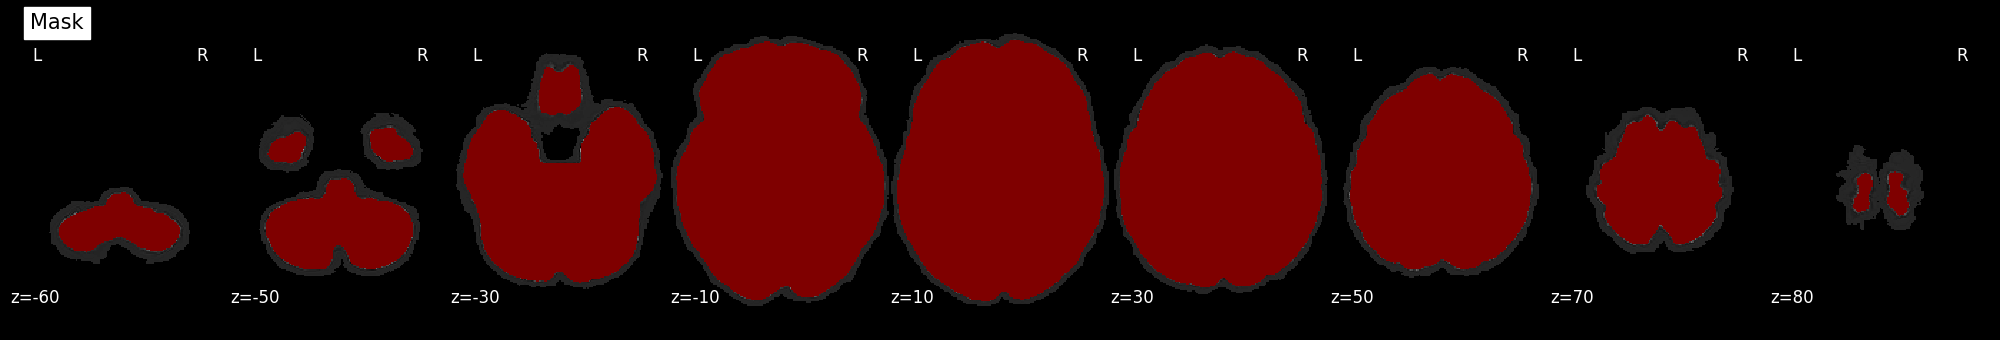

In [37]:
now = datetime.now()
print('Making a mask for analysis:',now.strftime("%H:%M:%S"))

#Make a mask with the whole brain

subj = models[4].subject_label

#print(subj) # to make sure it is our subject

mask_wb_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

#Load the whole brain mask
mask_img = load_img(mask_wb_filename)

## This bit can be used if you want to make a smaller select of the brain to study (e.g. to speed up analysis)
# .astype() makes a copy.

process_mask = mask_img.get_fdata().astype(int)

#Set slices below x in the z-dimension to zero (in voxel space)

process_mask[..., :10] = 0

#Set slices above x in the z-dimension to zero (in voxel space)

process_mask[..., 170:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

#Plot the mask on an anatomical background

plot_img(process_mask_img, 
         bg_img=anat_filename,
         #bg_img=mean_fmri,
         title="Mask", 
         display_mode="z",
         cut_coords=[-60,-50,-30,-10,10,30,50,70,80],
         vmin=.40, 
         cmap='jet', 
         threshold=0.9, 
         black_bg=True)


### 7. Run the Searchlight analysis

In [38]:
now = datetime.now()
print('Starting searchlight analysis:',now.strftime("%H:%M:%S"))

from nilearn.decoding import SearchLight
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = SearchLight(
    mask_img,
    estimator=GaussianNB(),
    process_mask_img=process_mask_img,
    radius=5, n_jobs=-1, #n_jobs=-1 means that all CPUs will be used
    verbose=10, cv=10)
searchlight.fit(fmri_img_train, conditions_train)

now = datetime.now()
print('Finishing searchlight analysis:',now.strftime("%H:%M:%S"))

Starting searchlight analysis: 16:23:22


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 173.5min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 175.0min remaining: 175.0min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 175.8min finished


Finishing searchlight analysis: 22:26:22


### 8. Save the variables

In [39]:
import pickle
import nilearn

import os
outdir='/work/JustinaRazanauskaite#2891/ACN/Portfolio_2/findings'
if not os.path.exists(outdir):
    os.mkdir(outdir)
#Save the searchlight model

# Saving the objects:
search_file=outdir+'/deck_trials_searchlight.pkl'
f = open(search_file, 'wb')
pickle.dump([searchlight, searchlight.scores_], f)
f.close()

now = datetime.now()
print('Searchlight output saved:',now.strftime("%H:%M:%S"))

Searchlight output saved: 22:26:23


### 8.2. Restore the variables

In [33]:
# Getting back the objects:
f = open('/work/JustinaRazanauskaite#2891/ACN/Portfolio_2/findings/deck_trials_searchlight.pkl', 'rb')
searchlight,searchlight_scores_ = pickle.load(f)
f.close()

### 9. Plot the outcome

Plotting and saving searchlight output (threshold:0.6): 22:26:44


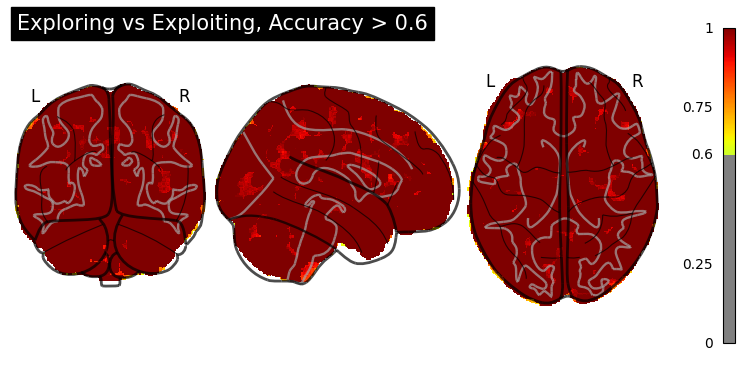

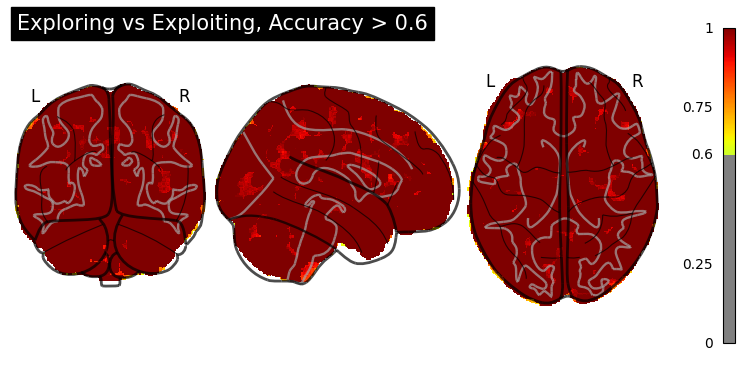

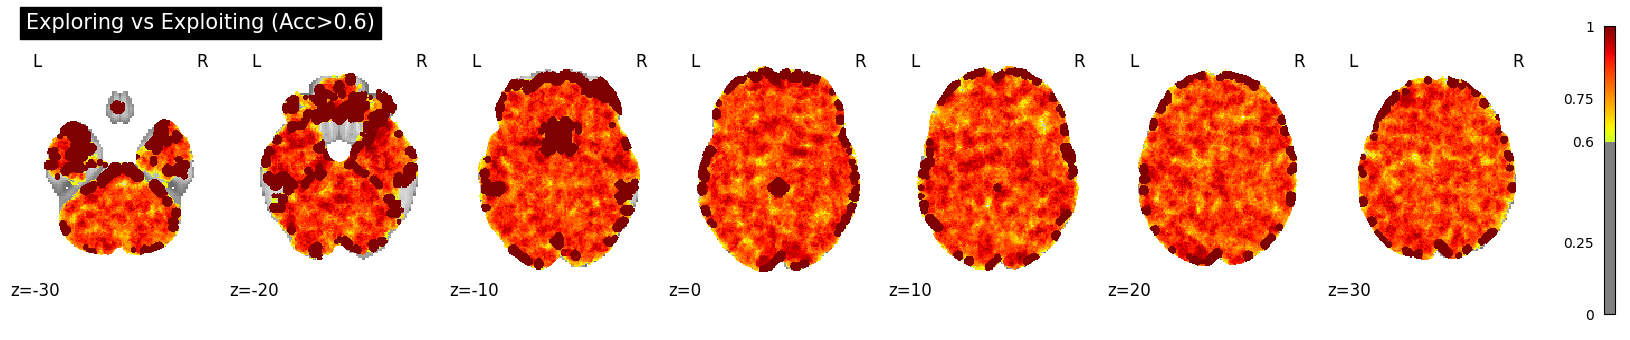

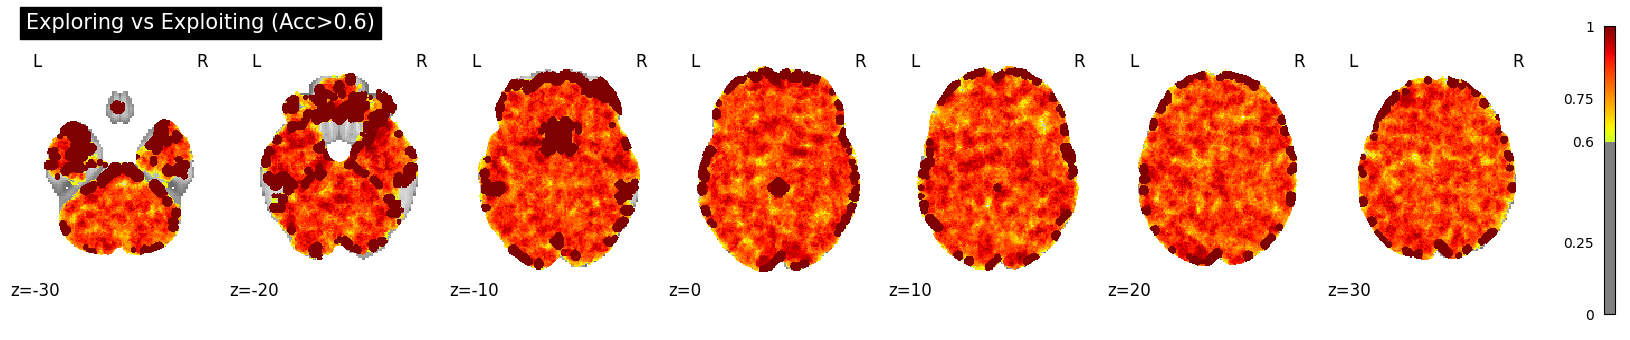

In [40]:
from nilearn import image, plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, load_img


outdir='/work/JustinaRazanauskaite#2891/ACN/Portfolio_2/findings'

now = datetime.now()
print('Plotting and saving searchlight output (threshold:0.6):',now.strftime("%H:%M:%S"))

# Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)


# The code below will plot the searchlight accuracy scores with an accuracy of 60% or higher (above the chance).
# It means that brain areas, that are better at differentiating Exploring versus Exploiting are shown.

plot_glass_brain(searchlight_img, 
                 cmap='jet',
                 colorbar=True, 
                 threshold=0.6,
                 title='Exploring vs Exploiting, Accuracy > 0.6',
                 plot_abs=False)

# Saving the above image:
fig = plotting.plot_glass_brain(searchlight_img, 
                                cmap='jet', 
                                colorbar=True, 
                                threshold=0.6, 
                                title='Exploring vs Exploiting, Accuracy > 0.6')

fig_file=outdir+'/iowa2024_sub-'+subj+'Exploring_vs_Exploiting_searchlightNB_glass.png'
fig.savefig(fig_file, dpi=300)
plt.show()

# The plot below shows slices of the brain at specified coordinates along a chosen dimension. It overlays searchlight accuracy
# map onto anatomical slices, and offer localized details than glass brain, where activations are seen across the entire brain.

plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Exploring vs Exploiting (Acc>0.6)')

# Saving the second plot:

fig_2 = plotting.plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Exploring vs Exploiting (Acc>0.6)')

fig_2_file=outdir+'/iowa2024_sub-'+subj+'Exploring_vs_Exploiting_searchlight_stat_map.png'
fig_2.savefig(fig_2_file, dpi=300)

plt.show()

### 10. Find the 500 most predictive voxels

In [41]:
print('Number of voxels in searchlight: ', searchlight.scores_.size)
#Find the percentile that makes the cutoff for the 500 best voxels

perc=100*(1-500.0/searchlight.scores_.size)
#Print percentile
print('Percentile for 500 most predictive voxels: ',perc)

#Find the cutoff
cut=np.percentile(searchlight.scores_,perc)
#Print cutoff
print('Cutoff for 500 most predictive voxels: ', cut)
#cut=0
#Make a mask using cutoff

#Load the whole brain mask
mask_img2 = load_img(mask_wb_filename)

# .astype() makes a copy.
process_mask2 = mask_img2.get_fdata().astype(int)
process_mask2[searchlight.scores_<=cut] = 0
process_mask2_img = new_img_like(mask_img2, process_mask2)


Number of voxels in searchlight:  8980290
Percentile for 500 most predictive voxels:  99.9944322510743
Cutoff for 500 most predictive voxels:  1.0


/tmp/ipykernel_388/144183062.py:21: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask2_img = new_img_like(mask_img2, process_mask2)
